In [1]:
#MacOS 兼容性操作
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM

import altair as alt
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

import nbimporter
import joblib

In [4]:
model = load_model('BTC_predict_test3.keras')
scaler = joblib.load('scaler.pkl')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
#define method to extract X and y
def extract_data(data, time_step):
    X = []
    y = []
    for i in range(len(data) - time_step):
        X.append([a for a in data[i: i + time_step]])
        y.append(data[i + time_step, :]) 
    X = np.array(X)
    #转化成RNN格式 (样本数,timestep, 每个数据的维度(特征数))
    #X = X.reshape(X.shape[0], time_step, X.shape[2])
    y = np.array(y)
    return X, y

In [6]:
time_step = 30

In [7]:
#load the test data
data_test = pd.read_csv('../BTC_price_train/ver2/BTC_price_test.csv')

# Reverse the order of the DataFrame
#data_test = data_test.iloc[::-1].reset_index(drop=True)
# Display the first 5 rows
print(data_test.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data_test.info())

| timeOpen   | Close   | Open    | High    | Low     | volume   | Chg.(%)   |
|:-----------|:--------|:--------|:--------|:--------|:---------|:----------|
| 2022/5/16  | 29849   | 31308.3 | 31312.4 | 29135.8 | 100250   | -0.05     |
| 2022/5/17  | 30437.5 | 29856.7 | 30720.1 | 29484.5 | 79630    | 0.02      |
| 2022/5/18  | 28683.7 | 30437.5 | 30687.9 | 28648.1 | 92030    | -0.06     |
| 2022/5/19  | 30305.9 | 28700.4 | 30525.1 | 28682.1 | 101380   | 0.06      |
| 2022/5/20  | 29178.6 | 30305.9 | 30735.1 | 28738.5 | 98780    | -0.04     |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  764 non-null    object 
 1   Close     764 non-null    float64
 2   Open      764 non-null    float64
 3   High      764 non-null    float64
 4   Low       764 non-null    float64
 5   volume    764 non-null    float64
 6   Chg.(%)   764 non-null    float64

In [9]:
#define the price
price_test = data_test.drop(['timeOpen', 'Chg.(%)'], axis=1)

#normalize
scaled_test_data = scaler.transform(price_test)  # 使用在训练集上拟合的scaler来转换测试集

In [26]:
X_test, y_test = extract_data(scaled_test_data, time_step)

print(X_test.shape, y_test.shape)

(734, 30, 5) (734, 5)


In [27]:
#predict
y_test_predict_norm = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


In [28]:
y_test_predict = scaler.inverse_transform(y_test_predict_norm)
y_test_raw = scaler.inverse_transform(y_test)

In [29]:
y_test_predict_close = y_test_predict[:, 0]
y_test_close = y_test_raw[:, 0]

y_test_predict_open = y_test_predict[:, 1]
y_test_open = y_test_raw[:, 1]

y_test_predict_high = y_test_predict[:, 2]
y_test_high = y_test_raw[:, 2]

y_test_predict_low = y_test_predict[:, 3]
y_test_low = y_test_raw[:, 3]

In [31]:
print(y_test_close.shape)

(734,)


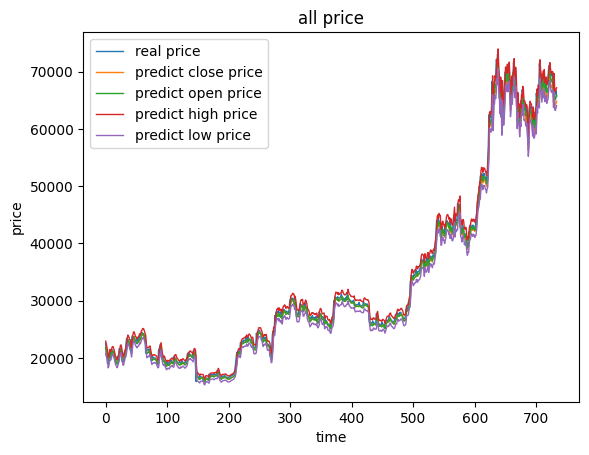

In [34]:
time_test = list(range(len(y_test_close)))

fig1 = plt.figure()
plt.plot(time_test, y_test_close, label='real price',linewidth = 1)
plt.plot(time_test, y_test_predict_close, label='predict close price', lw = 1)
plt.plot(time_test, y_test_predict_open, label='predict open price', lw = 1)
plt.plot(time_test, y_test_predict_high, label='predict high price', lw = 1)
plt.plot(time_test, y_test_predict_low, label='predict low price', lw = 1)

plt.legend()
plt.title('all price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

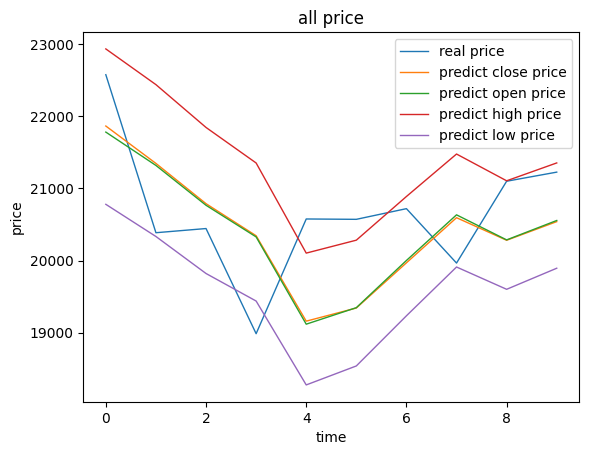

In [33]:
time_test = list(range(len(y_test_close)))[0:10]

fig2 = plt.figure()
plt.plot(time_test, y_test_close[0:10], label='real price',linewidth = 1)
plt.plot(time_test, y_test_predict_close[0:10], label='predict close price', lw = 1)
plt.plot(time_test, y_test_predict_open[0:10], label='predict open price', lw = 1)
plt.plot(time_test, y_test_predict_high[0:10], label='predict high price', lw = 1)
plt.plot(time_test, y_test_predict_low[0:10], label='predict low price', lw = 1)

plt.legend()
plt.title('all price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [40]:
result_y_test_close = y_test_close.reshape(-1, 1)
result_y_predict_close = y_test_predict_close.reshape(-1, 1)
result_y_predict_open = y_test_predict_open.reshape(-1, 1)
result_y_predict_high = y_test_predict_high.reshape(-1, 1)
result_y_predict_low = y_test_predict_low.reshape(-1, 1)

print(y_test_close.shape, result_y_test_close.shape, y_test_predict_close.shape, result_y_predict_close.shape)

result = np.concatenate((result_y_test_close, result_y_predict_close, result_y_predict_open, result_y_predict_high, result_y_predict_low), axis=1)
print(result.shape)

result = pd.DataFrame(result, columns=['real_close_price_test', 'predict_price_test_close', 'predict_price_test_open', 'predict_price_test_high', 'predict_price_test_low'])
result.to_csv('BTC_predict_allprice.csv')

(734,) (734, 1) (734,) (734, 1)
(734, 5)
